## Prep Notebook

### DRIVE MOUNT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### IMPORTS

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
import seaborn as sns
import keras.backend as K

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import Input
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.layers import BatchNormalization
from keras.models import Sequential, Model

In [5]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [6]:
import mlflow
mlflow.set_tracking_uri("https://dagshub.com/ArtificialTruth/ThoughtVizReproduced.mlflow")

## LOAD EEG DATA

In [7]:
from sklearn.model_selection import train_test_split

def load_eeg(path):
    eeg = pickle.load(open(f'{path}/data.pkl', 'rb'), encoding='latin1')
    x_train, x_test = eeg['x_train'], eeg['x_test']
    y_train, y_test = eeg['y_train'], eeg['y_test']
    x_train, x_vali, y_train, y_vali = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

    eeg = {'x_train': x_train, 'y_train': y_train,
                  'x_vali': x_vali, 'y_vali': y_vali,
                  'x_test': x_test, 'y_test': y_test}

    return eeg

In [8]:
EEG_DATASETS = {
    'obj': load_eeg('/content/drive/MyDrive/PBL/thoughtviz/data/processed/eeg/obj'),
    'char': load_eeg('/content/drive/MyDrive/PBL/thoughtviz/data/processed/eeg/char'),
    'digit': load_eeg('/content/drive/MyDrive/PBL/thoughtviz/data/processed/eeg/digit')
}

## LOAD IMG DATA

In [9]:
def load_img(path, dataset):
    img = pickle.load(open(f'{path}/{dataset}.pkl', 'rb'), encoding='latin1')
    return img

In [10]:
obj_img = load_img('/content/drive/MyDrive/PBL/thoughtviz/data/processed/images/ImageNet-64x64resize-normalized-rgb', 'obj')
char_img = load_img('/content/drive/MyDrive/PBL/thoughtviz/data/processed/images/Char-Font-28x28-resize-normalized-invert', 'char')

In [11]:
obj_img['x_train'].shape, obj_img['y_train'].shape

((539, 64, 64, 3), (539, 10))

In [12]:
char_img['x_train'].shape, char_img['y_train'].shape

((6096, 28, 28, 1), (6096, 10))

## LOAD EEG CLASSIFIER

In [13]:
EEG_CLASSIFIERS = {}

In [14]:
EEG_CLASSIFIERS = {
    'char': mlflow.tensorflow.load_model('runs:/28734c5bcd7848c083ed77b9396c6ede/model'),
    'obj': mlflow.tensorflow.load_model('runs:/95c7989acd5544c4ae97b64e882a3393/model'),
    'digit': mlflow.tensorflow.load_model('runs:/d51cf80f25f44422938180b148c5f776/model')
}

### Train Objects

In [15]:
def train_eeg_classifier(dataset, epochs):
  EEG_CLASSIFIERS[dataset].compile(
      optimizer=keras.optimizers.legacy.Adam(learning_rate=(10 ** -4),
      decay=1 * (10 ** -3)), loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=['accuracy']
  )

  early_stopping_callback = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', min_delta=0, patience=100,
      restore_best_weights=True, verbose=1
  )

  callbacks = [early_stopping_callback]

  EEG_CLASSIFIERS[dataset].fit(
      EEG_DATASETS[dataset]['x_train'], EEG_DATASETS[dataset]['y_train'],
      epochs=epochs, validation_data=(EEG_DATASETS[dataset]['x_vali'],
                                   EEG_DATASETS[dataset]['y_vali']),
      batch_size=32, callbacks=callbacks
  )

  loss, accuracy = EEG_CLASSIFIERS[dataset].evaluate(
      EEG_DATASETS[dataset]['x_test'], EEG_DATASETS[dataset]['y_test']
  )

In [64]:
train_eeg_classifier('obj', 100)
train_eeg_classifier('char', 30)
train_eeg_classifier('digit', 30)

Epoch 1/100
1135/1135 [==============================] - 11s 9ms/step - loss: 2.2773 - accuracy: 0.3706 - val_loss: 1.3689 - val_accuracy: 0.5475
Epoch 2/100
1135/1135 [==============================] - 7s 6ms/step - loss: 1.1820 - accuracy: 0.6134 - val_loss: 1.0029 - val_accuracy: 0.6833
Epoch 3/100
1135/1135 [==============================] - 10s 9ms/step - loss: 0.9198 - accuracy: 0.7049 - val_loss: 0.8240 - val_accuracy: 0.7535
Epoch 4/100
1135/1135 [==============================] - 9s 8ms/step - loss: 0.7666 - accuracy: 0.7632 - val_loss: 0.7077 - val_accuracy: 0.7962
Epoch 5/100
1135/1135 [==============================] - 9s 8ms/step - loss: 0.6614 - accuracy: 0.7998 - val_loss: 0.6170 - val_accuracy: 0.8295
Epoch 6/100
1135/1135 [==============================] - 10s 9ms/step - loss: 0.5890 - accuracy: 0.8263 - val_loss: 0.5629 - val_accuracy: 0.8535
Epoch 7/100
1135/1135 [==============================] - 7s 6ms/step - loss: 0.5417 - accuracy: 0.8438 - val_loss: 0.4987 - val

In [65]:
CROPPED_EEG_CLASSIFIERS = {
    'obj': keras.Model(inputs=EEG_CLASSIFIERS['obj'].input, outputs=EEG_CLASSIFIERS['obj'].get_layer('dense_3').output),
    'char': keras.Model(inputs=EEG_CLASSIFIERS['char'].input, outputs=EEG_CLASSIFIERS['char'].get_layer('dense_3').output),
    'digit': keras.Model(inputs=EEG_CLASSIFIERS['digit'].input, outputs=EEG_CLASSIFIERS['digit'].get_layer('dense_3').output)
}

## EVAL TOOLS

In [19]:
class_idx_to_label = {
    'digit': {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'},
    'char': {0: 'A', 1: 'C', 2: 'F', 3: 'H', 4: 'J', 5: 'M', 6: 'P', 7: 'S', 8: 'T', 9: 'Y'},
    'obj': {0: 'Apple', 1: 'Car', 2: 'Dog', 3: 'Gold', 4: 'Mobile', 5: 'Rose', 6: 'Scooter', 7: 'Tiger',
            8: 'Wallet', 9: 'Watch'}
}

In [20]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = img[:, :, 0]
    return image

In [71]:
def reshape_labels(labels, image_size):
    labels = labels[:, :, None, None]
    labels = tf.repeat(
        labels, repeats=[image_size * image_size]
    )
    labels = tf.reshape(
        labels, (-1, 10, image_size, image_size)
    )
    labels = tf.transpose(labels, [0, 2, 3, 1])
    return labels

## LOAD GANS MODEL

In [66]:
GANS = {
    'obj': mlflow.tensorflow.load_model('runs:/7cdfbb02525e43aaad5f3c2412923ec3/model'),
    'char': mlflow.tensorflow.load_model('runs:/7f4180d978b246b2aef5e28c272086e1/model'),
    'digit': mlflow.tensorflow.load_model('runs:/87d08119e1cd4e56a3bc9db67ffa6563/model')
}

### OBJECTS

In [73]:
def evaluate_GAN(dataset, gan, channels, era):
  cmap = 'gray'
  cmap_dict = {'digit': 'gray', 'char': 'gray', 'obj': None}

  eeg_encoding = CROPPED_EEG_CLASSIFIERS[dataset](EEG_DATASETS[dataset]['x_vali'])
  eeg_label = EEG_DATASETS[dataset]['y_vali']
  reshape_dict = {'digit': 28, 'char': 28, 'obj': 64}

  if era == 'old':
    eeg_label = reshape_labels(eeg_label,reshape_dict[dataset])
    cmap = cmap_dict[dataset]

  idx = random.sample(range(eeg_encoding.shape[0]), k = 20)
  noise = tf.random.normal((20,100))
  eeg_x = tf.gather(eeg_encoding, indices = idx)
  eeg_y = tf.gather(eeg_label, indices = idx)

  gen_images = gan.get_layer(name='generator')({"noise_input": noise,"eeg_encoding": eeg_x, 'eeg_class_labels': eeg_y})
  gen_img = tf.squeeze(gen_images)
  _, axs = plt.subplots(1, 20, figsize=(20, 20))
  axs = axs.flatten()

  for img, ax in zip(gen_img[:, :,:,:channels], axs):
    ax.imshow(img, cmap = cmap_dict[dataset])
    ax.axis('off')
  for y in eeg_y:
    print(class_idx_to_label[dataset][np.argmax(y)], end='\t')
  plt.subplots_adjust(wspace=0.05, hspace=0.05)
  plt.show()

C	H	S	A	C	F	H	F	H	A	H	S	S	T	M	J	M	A	C	M	

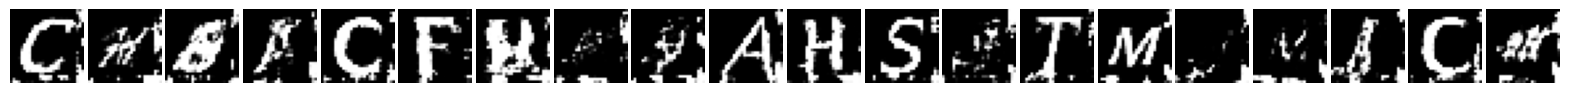

In [74]:
evaluate_GAN('char', GANS['char'], 1, 'new')

Car	Apple	Tiger	Wallet	Car	Scooter	Tiger	Dog	Scooter	Car	Car	Mobile	Watch	Rose	Dog	Car	Rose	Tiger	Wallet	Scooter	

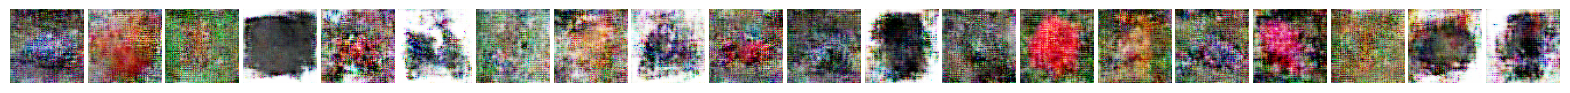

In [75]:
evaluate_GAN('obj', GANS['obj'], 3, 'new')

3	7	1	3	5	2	6	0	6	5	1	3	1	9	1	4	4	7	0	1	

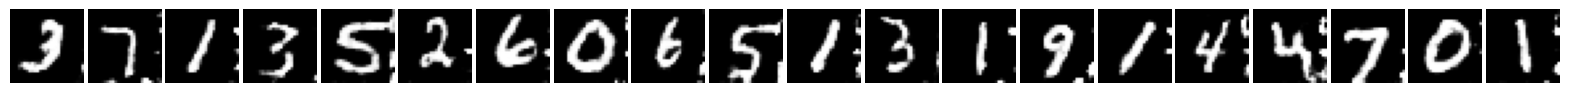

In [76]:
evaluate_GAN('digit', GANS['digit'], 1, 'old')

In [78]:
def produce_images_for_report(gan, dataset, channels, era):
    cmap = 'gray'
    reshape_dict = {'digit': 28, 'char': 28, 'obj': 64}
    cmap_dict = {'digit': 'gray', 'char': 'gray', 'obj': None}

    eeg_encoding = CROPPED_EEG_CLASSIFIERS[dataset](EEG_DATASETS[dataset]['x_vali'])
    eeg_label = EEG_DATASETS[dataset]['y_vali']
    reshape_dict = {'digit': 28, 'char': 28, 'obj': 64}

    if era == 'old':
      eeg_label = reshape_labels(eeg_label,reshape_dict[dataset])
      cmap = cmap_dict[dataset]

    classes = np.argmax(eeg_label,axis = 1)

    counter = 0
    list_images = []
    list_labels = []
    # apple, scooter, rose, watch, car, tiger, dog, wallet, gold, mobile
    class_order_thoughtviz_report = [0, 6, 5, 9, 1, 7, 2, 8, 3, 4]

    for i in range(10):
      x_masked = np.where(classes == class_order_thoughtviz_report[counter], classes, 100)
      indices = [i for i, x in enumerate(x_masked) if x == class_order_thoughtviz_report[counter]]
      counter += 1
      idx = random.sample(indices, k = 9)
      noise = tf.random.normal((9,100))
      eeg_x = tf.gather(eeg_encoding, indices = idx)
      eeg_y = tf.gather(eeg_label, indices = idx)
      gen_images = gan.get_layer(name='generator')(
          {"noise_input":noise
            ,"eeg_encoding": eeg_x,
            'eeg_class_labels': eeg_y})
      gen_img = tf.squeeze(gen_images)
      list_images.append(gen_img)
    gen_img = tf.concat(list_images,axis = 0)
    _, axs = plt.subplots(10, 9, figsize=(8, 8))
    axs = axs.flatten()
    for img, ax in zip(gen_img[:, :,:,:channels], axs):
      ax.imshow(img, cmap = cmap_dict[dataset])
      ax.axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


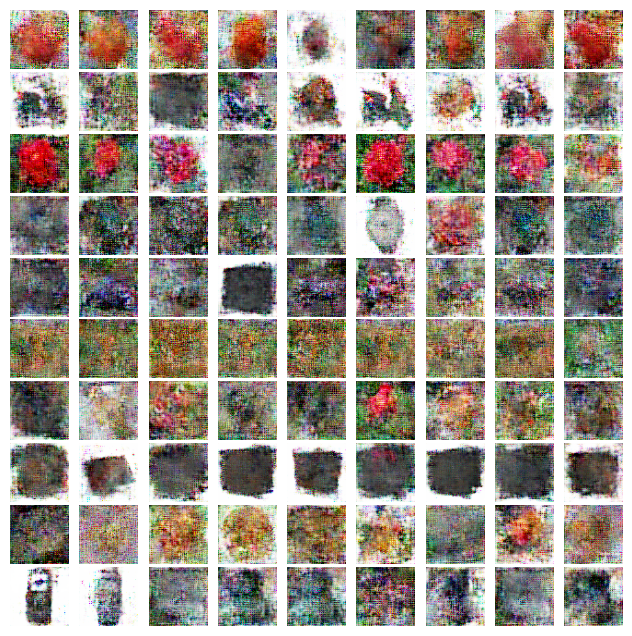

In [79]:
produce_images_for_report(GANS['obj'], 'obj', 3, 'new')

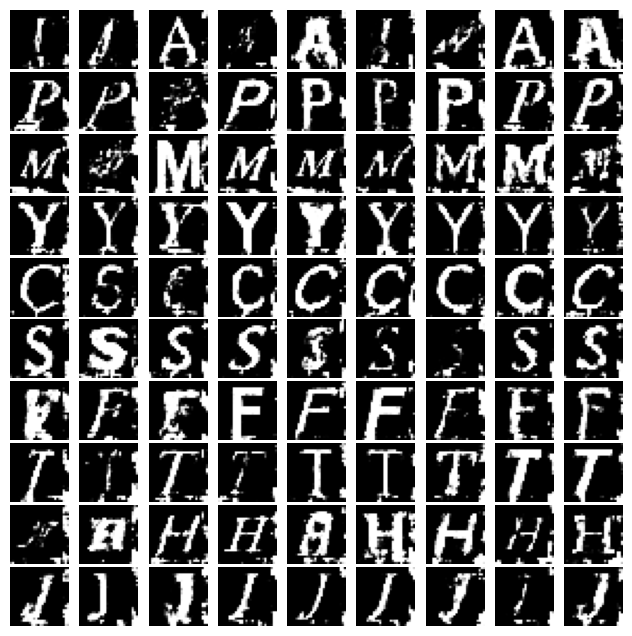

In [80]:
produce_images_for_report(GANS['char'], 'char', 1, 'new')